# Tutorial 1 - Introduction to PyRossGeo

- [Skip to **Tutorial 2: Handling PyRossGeo output**](../tutorial2-handling-PyRossGeo-output/tutorial2-handling-PyRossGeo-output.ipynb)
- [Skip to **Tutorial 3: Handling the simulation output**](../tutorial3-interventions/tutorial3-interventions.ipynb)
- [Go to the PyRossGeo documentation](https://github.com/lukastk/PyRossGeo/blob/master/docs/Documentation.md)

This tutorial assumes knowledge of the PyRossGeo model. Please take a look at the [model description](https://github.com/lukastk/PyRossGeo/blob/master/docs/model.pdf) if you have not yet done so.

In this tutorial we will introduce the core functionalities of PyRossGeo. We will first simulate a single node with SIR dynamics, and then we will proceed  to simulate a network of nodes with SEAIR dynamics.

In [1]:
# Compile and import local pyrossgeo module
import os, sys
owd = os.getcwd()
os.chdir('../../')
sys.path.insert(0,'../../')
!python setup.py build_ext --inplace
os.chdir(owd)

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pyrossgeo

import pandas as pd
import json

running build_ext


## 1.1 Age-structured SIR on a single node

The following configuration files are used in a PyRossGeo simulation:
- [model.json](https://github.com/lukastk/PyRossGeo/blob/master/docs/Configuration%20files.md#modeljson)
- [node_parameters.csv](https://github.com/lukastk/PyRossGeo/blob/master/docs/Configuration%20files.tex.md#node_parameterscsv)
- [cnode_parameters.csv](https://github.com/lukastk/PyRossGeo/blob/master/docs/Configuration%20files.md#cnode_parameterscsv)
- [contact_matrices.json](https://github.com/lukastk/PyRossGeo/blob/master/docs/Configuration%20files.md#contact_matricesjson)
- [node_cmatrices.csv](https://github.com/lukastk/PyRossGeo/blob/master/docs/Configuration%20files.md#node_cmatricescsv)
- [cnode_cmatrices.csv](https://github.com/lukastk/PyRossGeo/blob/master/docs/Configuration%20files.md#cnode_cmatricescsv)
- [node_populations.csv](https://github.com/lukastk/PyRossGeo/blob/master/docs/Configuration%20files.md#node_populationscsv)
- [commuter_networks.csv](https://github.com/lukastk/PyRossGeo/blob/master/docs/Configuration%20files.md#commuter_networkscsv)

We will go through the structure of these files briefly in this tutorial, but for more detailed descriptions please click the links above. The configuration files used for section 1.1 of this tutorial can be found [here](https://github.com/lukastk/PyRossGeo/tree/master/examples/tutorial1-introduction-to-pyrossgeo/SIR_single_node). 

### 1.1.1 Defining the model ([model.json](https://github.com/lukastk/PyRossGeo/blob/master/docs/Configuration%20files.md#modeljson))

`model.json` defines the model to use for the local epidemiological dynamics at each node. Below you can see the `model.json` for SIR.

In [2]:
with open('./SIR_single_node/model.json', 'r') as f:
    print(f.read())

{
    "classes" : ["S", "I", "R"],

    "S" : {
        "linear"    : [],
        "infection" : [ ["I", "-beta"] ]
    },

    "I" : {
        "linear"    : [ ["I", "-gamma"] ],
        "infection" : [ ["I", "beta"] ]
    },

    "R" : {
        "linear"    : [ ["I", "gamma"] ],
        "infection" : []
    }
}



The list of all epidemiological classes are defined using in the list `"classes" : ["S", "I", "R"]`. The dynamics of each individual class is then defined using the

```json
"I" : {
        "linear"    : [ ["I", "-gamma"] ],
        "infection" : [ ["I", "beta"] ]
    },
```

construction, where each linear and each non-linear infection term are given. For example, we can read off the dynamics of the $I$ class as

$$
\dot{I}^\mu = \beta \sum_\nu C_{\mu \nu} \frac{I^\nu}{N^\nu} - \gamma I^\mu
$$

where the $\mu$ corresponds the age bracket. Indices giving the home and locations $(i,j)$ have been omitted. Note that the models are automatically given an age-structure. The age-contact structure of the simulation is defined in section 1.1.3.

The whole system of equations are:

$$
\begin{aligned}
\dot{S}^\mu & = - \beta \sum_\nu C_{\mu \nu} \frac{I^\nu}{N^\nu} S^\mu \\
\dot{I}^\mu & = \beta \sum_\nu C_{\mu \nu} \frac{I^\nu}{N^\nu} - \gamma I^\mu \\
\dot{R}^\mu & = \gamma I^\mu
\end{aligned}
$$

### 1.1.2 Setting the model parameters ([node_parameters.csv](https://github.com/lukastk/PyRossGeo/blob/master/docs/Configuration%20files.tex.md#node_parameterscsv) and [cnode_parameters.csv](https://github.com/lukastk/PyRossGeo/blob/master/docs/Configuration%20files.md#cnode_parameterscsv))

Next, we must define the model parameters `beta` and `gamma`. Below you can see the `node_parameters.csv` for this example.

In [3]:
pd.read_csv('./SIR_single_node/node_parameters.csv')

,Home,Location,Age,Area,beta,gamma
0,ALL,ALL,ALL,1,0.01,0.03


Here we have set $\beta_{ij}^\alpha = 0.01$ and $\gamma_{ij}^\alpha = 0.03$ for all nodes $(\alpha, i, j)$. We have also set the area to $A_i = 1km^2$ for all locations $i$. The area is used in PyRossGeo to scale the infectivity of the SIR dynamics with population density.

Recall that a *node* in PyRossGeo is not a geographical location, but rather the 3-tuple $(\alpha, i, j)$, corresponding to age-group, residence and location. In other words, PyRossGeo not only keeps track of how many people populate each location $j$, but also where they live, and what age they are.

The parameters of the commuterverse is set in a similar way, using `cnode_parameters.csv`.

In [4]:
pd.read_csv('./SIR_single_node/cnode_parameters.csv')

,Home,From,To,Age,Area,beta,gamma
0,ALL,ALL,ALL,ALL,1,0.01,0.03


Since we are only modelling a single node, `cnode_parameters.csv` serves no purpose in the simulation. Regardless, the file is still required for the initialisation of the simulation.

### 1.1.3 Contact structure ([contact_matrices.json](https://github.com/lukastk/PyRossGeo/blob/master/docs/Configuration%20files.md#contact_matricesjson), [node_cmatrices.csv](https://github.com/lukastk/PyRossGeo/blob/master/docs/Configuration%20files.md#node_cmatricescsv) and [cnode_cmatrices.csv](https://github.com/lukastk/PyRossGeo/blob/master/docs/Configuration%20files.md#cnode_cmatricescsv))

The contact matrices that are to be used in the simulation are defined in the file `contact_matrices.json`:

In [5]:
with open('./SIR_single_node/contact_matrices.json', 'r') as f:
    print(f.read())

{
    "C_main" : [
                  [10, 5,  0,  0 ],
                  [5,  10, 3,  0 ],
                  [0,  3,  10, 6 ],
                  [0,  0,  6,  10]
               ]
}



Here we see that we have a single contact matrix `C_main`, with 4 age groups. Let's interpret $\alpha=0,1,2,3,4$ as *child*, *young adult*, *adult* and *elderly* respectively. We can then read off from `C_main` that:
- $C^\text{home}_{\mu \mu}=10$. All age-groups have 10 encounters with members from their own group each day
- $C^\text{home}_{12}=C^\text{home}_{21}=5$. Children and young adults have 5 mutual interactions every day
- $C^\text{home}_{32}=C^\text{home}_{23}=3$. Young adults and adults have 3 mutual interactions every day
- $C^\text{home}_{43}=C^\text{home}_{34}=6$. Adults and the elderly have 6 mutual interactions every day

Which contact matrix to use for which node and commuter nodes is set using `node_cmatrices.csv` and `cnode_cmatrices.csv`.

In [6]:
pd.read_csv('./SIR_single_node/node_cmatrices.csv')

,Home,Location,S,I,R
0,ALL,ALL,NaN,C_main,NaN


In [7]:
pd.read_csv('./SIR_single_node/cnode_cmatrices.csv')

,Home,From,To,S,I,R
0,ALL,ALL,ALL,NaN,C_main,NaN


Note the `NaN` under the $S$ and $R$ classes. This is because contact matrices are only applicable for infection classes (which is $I$ in this case).

### 1.1.4 Populating the simulation ([node_populations.csv](https://github.com/lukastk/PyRossGeo/blob/master/docs/Configuration%20files.md#node_populationscsv))

The population of each node is set using `node_populations.csv`.

In [8]:
pd.read_csv('./SIR_single_node/node_populations.csv')

,Home,Location,S0,I0,R0,S1,I1,R1,S2,I2,R2,S3,I3,R3
0,0,0,100,1,0,200,0,0,300,0,0,250,0,0


Here we have assigned various numbers of susceptible children, young adults, adults and elderly to our single node. We have also seeded the node with a single infected child.

### 1.1.5 The commuter network ([commuter_networks.csv](https://github.com/lukastk/PyRossGeo/blob/master/docs/Configuration%20files.md#commuter_networkscsv))

As we are only considering a single node in this example, the commuter network file is empty. The file is still required for the initialisation of the simulation.

In [9]:
pd.read_csv('./SIR_single_node/commuter_networks.csv')

,Age,Home,From,To,# to move,% to move,t1,t2,ct1,ct2,Allow S,Allow I,Allow R


### 1.1.6 Initializing and running the simulation

To run the simulation we first create an instance of the `pyrossgeo.Simulation` class, and then initialize it by passing the path of the folder containing the configuration files.

**General note of caution:** <i>At the moment PyRossGeo does not have any checks in place to detect formatting errors in the configuration files. Any mistakes in the configuration files may lead to uncaught exceptions or unexpected simulation behaviour. This will be rectified in the future.</i>

In [10]:
sim = pyrossgeo.Simulation()
X_state = sim.initialize(sim_config_path='SIR_single_node')

`X_state` is a one-dimensional vector containing the initial conditions of the simulation, as specified by the configuration files.

An alternative way to initialize is by specifically passing the path for each file.

In [11]:
sim = pyrossgeo.Simulation()
X_state = sim.initialize(model_dat = 'SIR_single_node/model.json',
                         commuter_networks_dat = 'SIR_single_node/commuter_networks.csv',
                         node_parameters_dat = 'SIR_single_node/node_parameters.csv',
                         cnode_parameters_dat = 'SIR_single_node/cnode_parameters.csv',
                         contact_matrices_dat = 'SIR_single_node/contact_matrices.json',
                         node_cmatrices_dat = 'SIR_single_node/node_cmatrices.csv',
                         cnode_cmatrices_dat = 'SIR_single_node/cnode_cmatrices.csv',
                         node_populations_dat = 'SIR_single_node/node_populations.csv')

Calling `pyrossgeo.Simulation.initialize` without any arguments is equivalent to setting `sim_config_path='.'`. 

To run the simulation, we simply define a starting time, an end time, a time-step, and call `pyrossgeo.Simulation.simulate`.

In [12]:
t_start = 0
t_end = 200*24*60 # Time is measured in units of minutes
dt = 10 # The time-step is 10 minutes

sim_data = sim.simulate(X_state, t_start, t_end, dt, steps_per_save=1)

By specifying `steps_per_save=1` the state of the simulation is saved every simulation step and returned in `sim_data`. More on the structure of the `sim_data` in the [subsequent tutorial](../tutorial2-handling-PyRossGeo-output/tutorial2-handling-PyRossGeo-output.ipynb).

### 1.1.7 Plotting the results

We can now plot the result of the simulation using the data returned in `sim_data`.

Text(0.5, 0, 'Days')

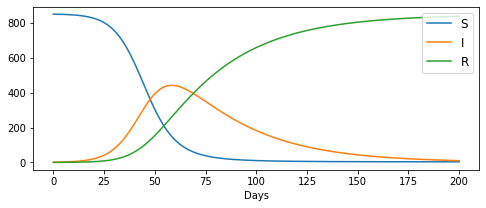

In [13]:
ts, node_data, cnode_data, location_data, community_data, network_data = pyrossgeo.utils.extract_simulation_data(sim_data)
ts_days = ts / (24*60)

plt.figure( figsize=(8,3) )

S = np.sum(network_data[:,:,0], axis=1) # Sum over all age-groups
I = np.sum(network_data[:,:,1], axis=1)
R = np.sum(network_data[:,:,2], axis=1)
N = S + I + R

plt.plot(ts_days, S, label="S")
plt.plot(ts_days, I, label="I")
plt.plot(ts_days, R, label="R")

plt.legend(loc='upper right', fontsize=12)
plt.xlabel('Days')
plt.show()

Plotting the individual age groups:

Text(0.5, 0, 'Days')

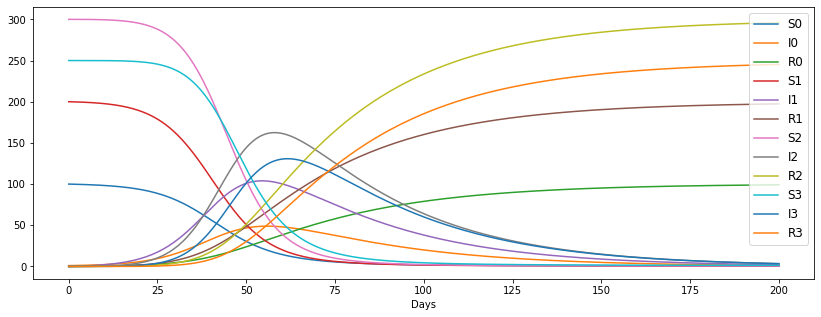

In [14]:
plt.figure( figsize=(14,5) )

S0 = network_data[:,0,0]
I0 = network_data[:,0,1]
R0 = network_data[:,0,2]
S1 = network_data[:,1,0]
I1 = network_data[:,1,1]
R1 = network_data[:,1,2]
S2 = network_data[:,2,0]
I2 = network_data[:,2,1]
R2 = network_data[:,2,2]
S3 = network_data[:,3,0]
I3 = network_data[:,3,1]
R3 = network_data[:,3,2]

plt.plot(ts_days, S0, label="S0")
plt.plot(ts_days, I0, label="I0")
plt.plot(ts_days, R0, label="R0")
plt.plot(ts_days, S1, label="S1")
plt.plot(ts_days, I1, label="I1")
plt.plot(ts_days, R1, label="R1")
plt.plot(ts_days, S2, label="S2")
plt.plot(ts_days, I2, label="I2")
plt.plot(ts_days, R2, label="R2")
plt.plot(ts_days, S3, label="S3")
plt.plot(ts_days, I3, label="I3")
plt.plot(ts_days, R3, label="R3")

plt.legend(loc='upper right', fontsize=12)
plt.xlabel('Days')
plt.show()

## 1.2 Age-structured SEAIR on three nodes

Now that we have covered the simulation of single-node SIR, we can go on to more interesting things.



### 1.2.1 Configuration files

The SEAIR model is defined as

$$
\begin{aligned}
\dot{S}^\mu & = - \lambda^\mu(t) S^\mu  \\
\dot{E}^\mu & = \lambda^\mu(t) S^\mu - \gamma_E E^\mu \\
\dot{A}^\mu & = \gamma_E E^\mu - \gamma_A A^\mu \\
\dot{I}^\mu & =  \gamma_A A^\mu  - \gamma_I I^\mu \\
\dot{R}^\mu & = \gamma_I I^\mu
\end{aligned}
$$

where

$$
\lambda^\mu(t) = \sum_\nu \left( \beta_I C^I_{\mu\nu} \frac{I^\nu}{N^\nu} + \beta_A C^A_{\mu\nu} \frac{A^\nu}{N^\nu} \right)
$$

In [15]:
with open('./SEAIR_network/model.json', 'r') as f:
    print(f.read())

{
    "classes" : ["S", "E", "A", "I", "R"],

    "S" : {
        "linear"    : [],
        "infection" : [ ["I", "-betaI"], ["A", "-betaA"] ]
    },

    "E" : {
        "linear"    : [ ["E", "-gammaE"] ],
        "infection" : [ ["I", "betaI"], ["A", "betaA"] ]
    },

    "A" : {
        "linear"    : [ ["E", "gammaE"], ["A", "-gammaA"] ],
        "infection" : []
    },

    "I" : {
        "linear"    : [ ["A", "gammaA"], ["I", "-gammaI"] ],
        "infection" : []
    },

    "R" : {
        "linear"    : [ ["I", "gammaI"] ],
        "infection" : []
    }
}



The model parameters for each node

In [16]:
pd.read_csv('./SEAIR_network/node_parameters.csv')

,Home,Loc,Age,Area,betaI,betaA,gammaE,gammaA,gammaI
0,ALL,ALL,ALL,1,0.02,0.02,0.03,0.03,0.03


The model parameters for each commuter node. We set the area of commuter nodes to be $0.1 km^2$ to reflect the fact that commutes tend to pack people more closely.

In [17]:
pd.read_csv('./SEAIR_network/cnode_parameters.csv')

,Home,From,To,Age,Area,betaI,betaA,gammaE,gammaA,gammaI
0,ALL,ALL,ALL,ALL,0.1,0.02,0.02,0.01,0.01,0.01


We define three different contact matrices, corresponding to people who are currently at their home nodes, are away, or are commuting.

In [18]:
with open('./SEAIR_network/contact_matrices.json', 'r') as f:
    print(f.read())

{
    "C_home" : [
        [7, 7, 7],
        [7, 7, 7],
        [7, 7, 7]
    ],

    "C_away" : [
        [1.0, 0.1, 0.1],
        [0.1, 1.0, 0.1],
        [0.1, 0.1, 1.0]
    ],

    "C_transport" : [
        [10, 10, 10],
        [10, 10, 10],
        [10, 10, 10]
    ]
}



Set contact matrices for each node

In [19]:
pd.read_csv('./SEAIR_network/node_cmatrices.csv')

,Home,Location,S,E,A,I,R
0,ALL,ALL,NaN,NaN,C_away,C_away,NaN
1,ALL,HOME,NaN,NaN,C_home,C_home,NaN


Note the keyword `HOME` in the `Location` column, which signifies that the value in the `Home` column should be copied. So the second row matches all nodes $(\alpha,i,j)$ where $i=j$.

Set contact matrices for each commuter node

In [20]:
pd.read_csv('./SEAIR_network/cnode_cmatrices.csv')

,Home,From,To,S,E,A,I,R
0,ALL,ALL,ALL,NaN,NaN,C_transport,C_transport,NaN


Node populations

In [21]:
pd.read_csv('./SEAIR_network/node_populations.csv')

,Home,Location,S0,E0,A0,I0,R0,S1,E1,A1,I1,R1,S2,E2,A2,I2,R2
0,0,0,1000,100,0,0,0,2000,0,0,0,0,500,0,0,0,0
1,1,1,700,0,0,0,0,1200,0,0,0,0,2000,0,0,0,0
2,1,1,2000,0,0,0,0,3000,0,0,0,0,1000,0,0,0,0


#### 1.2.1.1 Defining the commuter network

We will be using the commtuer network below:

In [112]:
pd.read_csv('./SEAIR_network/commuter_networks.csv')

,Home,From,To,Age,# to move,% to move,t1,t2,ct1,ct2,Allow S,Allow E,Allow A,Allow I,Allow R
0,0,0,1,0,210,-1,7,8,8.0,9.0,1,1,1,0,1
1,0,1,0,0,-1,1,17,18,18.0,19.0,1,1,1,1,1
2,0,0,2,1,500,-1,9,10,10.0,11.0,1,1,1,0,1
3,0,2,0,1,-1,1,18,19,19.0,20.0,1,1,1,1,1
4,1,1,0,1,100,-1,6,7,7.5,9.5,1,1,1,0,1
5,1,0,1,1,-1,1,16,17,17.0,18.0,1,1,1,1,1
6,2,2,1,0,300,-1,5,6,6.0,7.0,1,1,1,0,1
7,2,1,2,0,-1,1,20,21,21.0,22.0,1,1,1,1,1


Each row of the file defines a specific commute that occurs every day.

**First row:**

- It defines a commute that takes 210 people from node $(\alpha=0,i=0,j=0)$ to the node $(\alpha=0,i=0,j=1)$. In other words, it moves 210 people who live on location 0, and are currently at location 0, to location 1.
- The amount of people that are commuting is specified by the `# to move` column. Alternatively, we can also specify percentages of populations to commute using the `% to move`. It's important to note that both columns cannot be used at the same time. The column that is not used must be set to `-1`.
- The departure window is between `t1=7` and `t2=8`, meaning that people will start leaving at `t1`, and by `t2` all 210 people will have left.$^*$ The transport is modeled using a Gaussian pulse function (see the [model description](model.pdf) for more details). Time is given in units of hours, and should be in the range of a single day `[0, 24]`.
- People leaving the $(0,0,0)$ node will first enter the commuting node $(0,0,0 \to 1)$. The latter should be read as *the commuting node of residents of location 0, of age group 0, who are travelling from location 0 to 1*.
- The arrival window is between `ct1=8` and `ct2=9`. At `ct1` people will start to be moved from the commuting node to the destination node $(0,0,1)$, by $ct2$ everyone will have arrived.
- Using `Allow S`, `Allow E`... we can block certain classes from going on the commute. We have set `Allow I` to 0, in order to model the fact that symptomatic infecteds are likely to stay home and recuperate.

**Second row:**

- This is the return commute for the people who went to node $(0,0,1)$ from $(0,0,0)$ in the morning. We see that people will start leaving at 6PM, and arrive at home at 7PM.
- As opposed to the morning commute, we specify that 100% of the people at node $(0,0,1)$ should return to $(0,0,0)$.
- Note that we allow members of all classes to return home. This is important, as we would expect people who catch the virus away from home would return.

The rest of the rows defines commutes for other age classes and locations.

<i>$^*$ In practice, it is possible that fewer than the specified amount of people will travel. This is because of the fact that we are disallowing infected classes to move across the network (for example, if all residents of 0 are currently infected, then no people should be moving). See the [model description](https://github.com/lukastk/PyRossGeo/blob/master/docs/model.pdf) for more details on this.</i>

Note that we always specify `# to move` in the forward commute, and `% to move` in the return to commute. In most use-cases this is how commuting networks should be constructed. The reason why we specify percentages rather than absolute numbers in the return commute is because we might not know at run-time how many people actually went on the morning commute, due to the fact that we are barring certain classes from commuting.

### 1.2.2 Simulating the network

Before we start the simulation, we will create an adapted time-stepping schedule for the simulation using `pyrossgeo.utils.get_dt_schedule`.

In [56]:
ts, dts = pyrossgeo.utils.get_dt_schedule([
    (0,  2*60),     # Use a 2h time-step between 0-7
    (5*60,  1),     # Use a 10min time-step between 5-11
    (11*60, 2*60),  # Use a 2h time-step between 11-16
    (16*60, 1),     # Use a 10min time-step between 16-22
    (22*60, 2*60)   # Use a 2h time-step between 22-24
], end_time=24*60)

We pass a list of tuples `[(t0, dt0), (t1, dt1), ..., (tn, dtn)]`, and the function returns a tuple `(ts, dts)`, containing the corresponding times and the time-steps. Between `t0` and `t1`, the time-steps will be `dt0`. Between `t1` and `t2`, the time-steps will be `dt1`, and so on.

As transport generally requires a larger time-step than the epidemics, we define the time-stepping schedule with a 10 minute time-step during the commuting hours, and a two hour time-step anytime else.

We are now ready to run the simulation.

In [125]:
t_start = 0
t_end = 24*60*300 # Run for 200 days

sim = pyrossgeo.Simulation()
X_state = sim.initialize(sim_config_path='SEAIR_network')

sim_data = sim.simulate(X_state, t_start, t_end, dts, steps_per_save=1)

Various relevant data can be extracted from the simulation output `sim_data` using the function `pyrossgeo.utils.extract_simulation_data`.

In [126]:
ts, node_data, cnode_data, location_data, community_data, network_data = pyrossgeo.utils.extract_simulation_data(sim_data)

We can plot the epidemic for the network as a whole

Text(0.5, 0, 'Days')

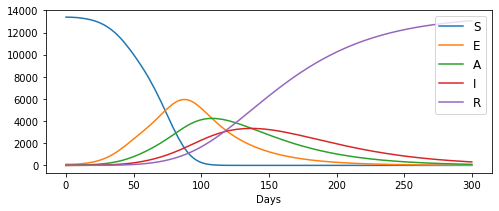

In [146]:
ts_days = ts / (24*60)

plt.figure( figsize=(8,3) )

S = np.sum(network_data[:,:,0], axis=1) # Sum over all age-groups
E = np.sum(network_data[:,:,1], axis=1)
A = np.sum(network_data[:,:,2], axis=1)
I = np.sum(network_data[:,:,3], axis=1)
R = np.sum(network_data[:,:,4], axis=1)

plt.plot(ts_days, S, label="S")
plt.plot(ts_days, E, label="E")
plt.plot(ts_days, A, label="A")
plt.plot(ts_days, I, label="I")
plt.plot(ts_days, R, label="R")

plt.legend(loc='upper right', fontsize=12)
plt.xlabel('Days')
plt.show()

We can plot for a single location.

Text(0.5, 1.0, 'Location 0')

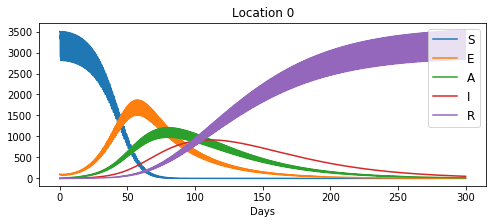

In [147]:
ts_days = ts / (24*60)

loc = 0

plt.figure( figsize=(8,3) )

S = np.sum(location_data[:,:,0,loc], axis=1)
E = np.sum(location_data[:,:,1,loc], axis=1)
A = np.sum(location_data[:,:,2,loc], axis=1)
I = np.sum(location_data[:,:,3,loc], axis=1)
R = np.sum(location_data[:,:,4,loc], axis=1)

plt.plot(ts_days, S, label="S")
plt.plot(ts_days, E, label="E")
plt.plot(ts_days, A, label="A")
plt.plot(ts_days, I, label="I")
plt.plot(ts_days, R, label="R")

#plt.plot(ts_days, S+E+A+I+R, label="N")

plt.legend(loc='upper right', fontsize=12)
plt.xlabel('Days')
plt.title("Location %s" % loc)
plt.show()

The thickness in the curves stem from the oscillations due to the daily commute. Zooming in, we get:

(0, 5)

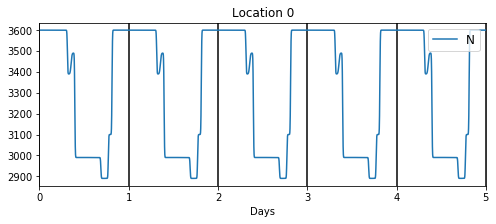

In [148]:
ts_days = ts / (24*60)

loc = 0

plt.figure( figsize=(8,3) )

S = np.sum(location_data[:,:,0,loc], axis=1)
E = np.sum(location_data[:,:,1,loc], axis=1)
A = np.sum(location_data[:,:,2,loc], axis=1)
I = np.sum(location_data[:,:,3,loc], axis=1)
R = np.sum(location_data[:,:,4,loc], axis=1)

for i in range(int(np.max(ts_days))):
    plt.axvline(i, color='black')
plt.plot(ts_days, S+E+A+I+R, label="N")

plt.legend(loc='upper right', fontsize=12)
plt.xlabel('Days')
plt.title("Location %s" % loc)

plt.xlim(0, 5)
plt.show()

This concludes the first part of the PyRossGeo tutorial.

- [Continue to **Tutorial 2: Handling PyRossGeo output**](../tutorial2-handling-PyRossGeo-output/tutorial2-handling-PyRossGeo-output.ipynb)
- [Skip to **Tutorial 3: Handling the simulation output**](../tutorial3-interventions/tutorial3-interventions.ipynb)
- [Go to the PyRossGeo documentation](https://github.com/lukastk/PyRossGeo/blob/master/docs/Documentation.md)